https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [3]:
import pandas as pd
import numpy as np
import itertools
import os
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

In [135]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [10]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [134]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:1]
    df['first3']= df['username'].str[:2]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['endwd']= df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    
pre0=pre1.copy()

add_features(pre0)

CPU times: user 272 ms, sys: 2 ms, total: 274 ms
Wall time: 276 ms


In [133]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [132]:
print pre0.columns.values
print pre0.columns.values[2:8]
pre0.head()

['username' 'fname.gender' 'last' 'last_two' 'last_three' 'first' 'first2'
 'first3' 'nchar' 'vowels.pct' 'digits.pct' 'endwd' 'last_is_vowel']
['last' 'last_two' 'last_three' 'first' 'first2' 'first3']


,username,fname.gender,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,endwd,last_is_vowel
0,billion,male,49,1419,5594,27,27,1000,7,0.428571,0.0,False,False
2,ArmenSoft,male,56,1034,7740,0,0,43,9,0.222222,0.0,False,False
3,okbookman,male,49,816,6707,41,41,1437,9,0.444444,0.0,False,False
4,revitupmedia,male,36,1142,3673,44,44,1517,12,0.500000,0.0,False,True
7,sakshiinfosys,male,55,1810,9322,45,45,1549,13,0.384615,0.0,False,False


In [129]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:8]
label_encode(pre0, to_be_encoded_cols)


CPU times: user 84 ms, sys: 1 ms, total: 85 ms
Wall time: 89 ms


In [19]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1])
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 11), (34482,), (14778, 11), (14778,)]


,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,endwd,last_is_vowel
117371,54,998,9526,18,18,756,11,0.272727,0.0,False,False


In [127]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [22]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 592 ms, sys: 1 ms, total: 593 ms
Wall time: 608 ms


In [23]:
print (11258+345)/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.785153606713


0.79131140885099471

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [28]:
import xgboost as xgb

In [86]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [87]:
d_train.get_label()

array([ 1.,  1.,  0., ...,  1.,  1.,  1.], dtype=float32)

In [88]:
a=.4
a = 1 if a>.5 else 0
a

0

In [123]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.9,
#     'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 11,
    'subsample': 0.9,
    'alpha': 0.1,
    'lambda':0.9,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [124]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.828461	test-acc:0.80586
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.825909	test-acc:0.819529
[40]	train-acc:0.82762	test-acc:0.819529
[60]	train-acc:0.829679	test-acc:0.819529
[80]	train-acc:0.832695	test-acc:0.819529
[100]	train-acc:0.836929	test-acc:0.819461
[120]	train-acc:0.84067	test-acc:0.819123
[140]	train-acc:0.845369	test-acc:0.818582
[160]	train-acc:0.850183	test-acc:0.818446
Stopping. Best iteration:
[65]	train-acc:0.830549	test-acc:0.8198



'!!! used 19.84 s'

accuracy 0.818581675464
statistic
male      14680
female       98
dtype: int64
Confusion matrix, without normalization
[[   39  2622]
 [   59 12058]]


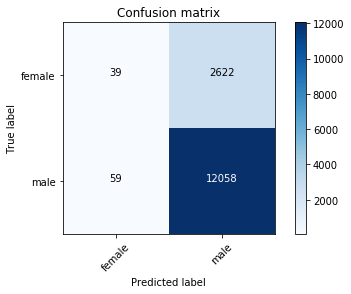

In [126]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

### other sklearn models

In [136]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm

In [137]:
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()

In [138]:
# accuracy_score(y_test, lsvm_pr)

In [139]:
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [140]:
# svm = SVC()
# svm

In [141]:
# %%time
# # svm.fit(X_train, y_train)

In [142]:
# from sklearn.neural_network import MLPClassifier

In [143]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [145]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [146]:
# pd.Series(neur_prd).value_counts()

In [147]:
# accuracy_score(y_test,neur_prd)

In [148]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [149]:
# from sklearn.naive_bayes import BernoulliNB

In [150]:
# nb = BernoulliNB()
# nb

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()